# Implementation of the sparse SVD
### Note: the first Python version of the function that works just like the author's matlab code runs in 3 min, 21 sec for best of 1 loop. Matlab = 89 seconds. 
## Final python optimized version ~ 39 seconds!!!

In [1]:
import pandas as pd
import numpy as np
from numba import jit
%load_ext line_profiler

print(__doc__)
from matplotlib import pyplot as plt
from sklearn.datasets import make_checkerboard
from sklearn.datasets import samples_generator as sg
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.metrics import consensus_score

Automatically created module for IPython interactive environment


In [2]:
#Load in data
X = np.loadtxt('data.txt')

In [3]:
@jit(nopython=True)
def gt(a, b):
    '''
    Helper function to compare floats
    a and b must be the same length
    '''
    result = np.zeros(len(a),dtype=np.float64)
    for i in range(len(a)):
        result[i] = a[i] >= b[i]
    return result

In [4]:
@jit(nopython=True)
def updateU(Bu,tmpI,n,d,ru,tu,winu,z,X,v1,sigsq):
    for i in range(0,ru):
        luc = tu[tmpI[i]]
        paralambda = luc/winu[winu!=0]
        
        tmp= np.multiply(np.sign(z[winu!=0]),gt(np.abs(z[winu!=0]),paralambda))  
        uc = np.multiply(tmp, np.abs(z[winu!=0])-paralambda)
        #Bu[i] = np.sum((X - np.outer(uc,v1))**2)/sigsq + (i+1)*np.log(n*d) #this works best
        acc = np.zeros(len(v1))
        acccum = 0
        for j in range(len(uc)):
            for k in range(len(v1)):
                acc[k] = acc[k] + (X[j][k] - (uc[j]*v1[k]))**2
        for c in range(len(v1)):
            acccum += acc[c]
        Bu[i] = acccum/sigsq + (i+1)*np.log(n*d)
    return Bu

In [5]:
@jit(nopython=True)
def updateV(Bv,tmpI,n,d,rv,tv,winv,z,u0,X,sigsq):
    for i in range(0,rv):
        lvc = tv[tmpI[i]]
        paralambda = lvc/winv[winv!=0]
        
        tmp= np.multiply(np.sign(z[winv!=0]), gt(np.abs(z[winv!=0]),paralambda))                         
        vc = np.multiply(tmp, np.abs(z[winv!=0])-paralambda)
        #Bv[i] = np.sum((X - np.outer(u0,vc))**2)/sigsq + (i+1)*np.log(n*d) #this works best
        acc = np.zeros(len(vc))
        acccum = 0
        for j in range(len(u0)):
            for k in range(len(vc)):
                acc[k] = acc[k] + (X[j][k] - (u0[j]*vc[k]))**2
        for c in range(len(vc)):
            acccum += acc[c]
        Bv[i] = acccum/sigsq + (i+1)*np.log(n*d)
    return Bv

In [6]:
def ssvd(X,param=None):
    n, d = X.shape
    threu = 1
    threv = 1
    gamu = 0
    gamv = 0
    t1, t2, t3 = np.linalg.svd(X)
    t3 = t3.T
    u0 = t1[:,0]
    v0 = t3[:,0]
    merr = 10**-4
    niter = 100
    ud = 1
    vd = 1
    iters = 0
    SST = np.sum(X**2)
    a = 3.7
    while (ud > merr or vd > merr):
        iters = iters + 1
        z = np.matmul(X.T,u0)
        winv = np.abs(z)**gamv
        sigsq = (SST - np.sum(z**2))/(n*d-d)
        tv = np.sort(np.append(np.abs(z**winv),0))
        rv = np.sum(tv>0)
        Bv = np.ones((d+1))*np.Inf
        tmpI = np.arange(d-1,-1,-1)
        Bv = updateV(Bv,tmpI,n,d,rv,tv,winv,z,u0,X,sigsq)
        Iv = np.argmin(Bv) + 1
        temp = np.sort(np.append(np.abs(np.multiply(z, winv)),0))
        lv = temp[d-Iv]
        paralambda = np.multiply(lv, winv[winv!=0])        
        tmp= np.multiply(np.sign(z[winv!=0]),gt(np.abs(z[winv!=0]),paralambda))  
        v1 = np.multiply(tmp, np.abs(z[winv!=0])-paralambda)   
        v1 = v1/np.sqrt(np.sum(v1**2)) #v_new
        z = np.matmul(X, v1)
        winu = np.abs(z)**gamu
        sigsq = (SST - np.sum(z**2))/(n*d-n)
        tu = np.sort(np.append(np.abs(np.multiply(z, winu)),0))
        ru = np.sum((tu>0).astype('int'))
        Bu = np.ones((n+1))*np.Inf
        tmpI = np.arange(n-1,-1,-1)
        Bu = updateU(Bu,tmpI,n,d,ru,tu,winu,z,X,v1,sigsq)
        Iu = np.argmin(Bu)+1
        temp = np.sort(np.append(np.abs(np.multiply(z, winu)),0))
        lu = temp[n-Iu]
        paralambda = lu/winu[winu!=0]        
        tmp= np.multiply(np.sign(z[winu!=0]),gt(np.abs(z[winu!=0]),paralambda))  
        u1 = np.multiply(tmp, np.abs(z[winu!=0])-paralambda)    
        u1 = u1/np.sqrt(np.sum(u1**2)) #u_new
        ud = np.sqrt(np.sum((u0-u1)**2))
        vd = np.sqrt(np.sum((v0-v1)**2)) 
        if iters > niter:
            print('Fail to converge! Increase the niter!')
            break
        u0 = u1
        v0 = v1
    u = u1
    v = v1
    return u,v,iters

In [105]:
#Obtain the answer
[u,v,iters] = ssvd(X)

In [8]:
#How long does this function take?
%timeit -r1 -n1 [u,v,iters] = ssvd(X)

1 loop, best of 1: 38.2 s per loop


# What functions are taking the longest?

In [ ]:
#Use line profiling
#Used primarily for debugging purposes, but can be used to see the processing requirements of the final algorithm
%lprun -s -f ssvd -T ssvd_results.txt ssvd(X)
%cat ssvd_results.txt

# Make simulated dataset:
# For more information on this example, please see:
`http://scikit-learn.org/stable/auto_examples/bicluster/plot_spectral_biclustering.html#sphx-glr-auto-examples-bicluster-plot-spectral-biclustering-py` 

consensus score: 1.0


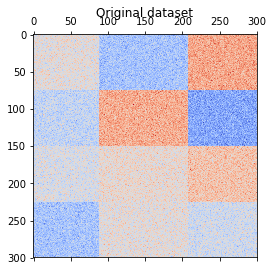

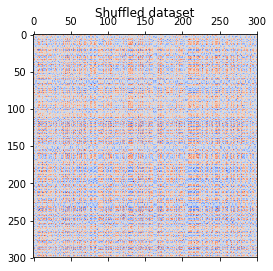

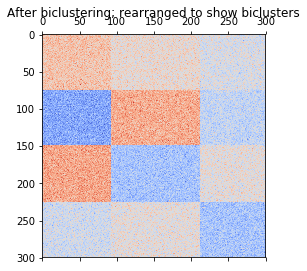

In [7]:
n_clusters = (4, 3)
data, rows, columns = make_checkerboard(
    shape=(300, 300), n_clusters=n_clusters, noise=10,
    shuffle=False, random_state=0)

plt.matshow(data, cmap=plt.cm.coolwarm_r)
plt.title("Original dataset")

data, row_idx, col_idx = sg._shuffle(data, random_state=0)
plt.matshow(data, cmap=plt.cm.coolwarm_r)
plt.title("Shuffled dataset")

model = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
model.fit(data)
score = consensus_score(model.biclusters_,
                        (rows[:, row_idx], columns[:, col_idx]))

print("consensus score: {:.1f}".format(score))

fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data, cmap=plt.cm.coolwarm_r)
plt.title("After biclustering; rearranged to show biclusters")
plt.show()

# Recreate Rank 1 Visual from Figure 1 from paper

In [8]:
#Rank 1
[u1,v1,iters] = ssvd(X)
Xstar1 = np.outer(u1, v1.T)
X = X-Xstar1
#Rank 2
# [u2,v2,iters] = ssvd(X)
# Xstar2 = np.outer(u2, v2.T)
# X = X-Xstar2
# #Rank 3
# [u3,v3,iters] = ssvd(X)
# Xstar3 = np.outer(u3, v3.T)
# X = X-Xstar3

In [9]:
v1sort = np.sort(v1)[::-1] #sort descending
u1sort = np.sort(u1)[::-1] #sort descending
x = np.outer(u1sort, v1sort.T)
x = x/np.max(np.abs(X))

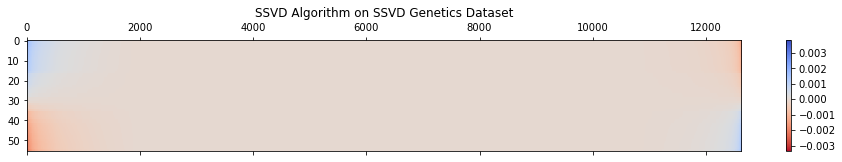

In [14]:
plt.matshow(x.T, cmap=plt.cm.coolwarm_r, aspect='auto');
plt.colorbar()
plt.title('SSVD Algorithm on SSVD Genetics Dataset', y=1.15)
plt.show()

In [18]:
model = SpectralBiclustering(n_clusters=4, method='log',
                             random_state=0)
model.fit(X)

SpectralBiclustering(init='k-means++', method='log', mini_batch=False,
           n_best=3, n_clusters=4, n_components=6, n_init=10, n_jobs=1,
           n_svd_vecs=None, random_state=0, svd_method='randomized')

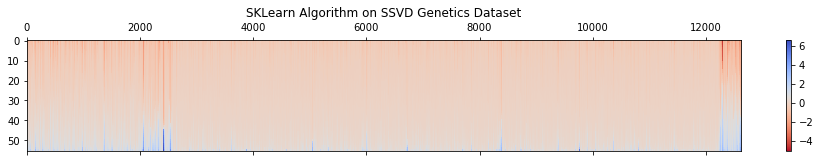

In [20]:
fit_data = X[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]
fit_data = np.sort(fit_data)

plt.matshow(fit_data.T, cmap=plt.cm.coolwarm_r, aspect='auto');
plt.colorbar()
plt.title('SKLearn Algorithm on SSVD Genetics Dataset', y=1.15)
plt.show()

#### Comparing the SSVD algorithm and the SKLearn algorithm on the sparse Genetics dataset, we can see that the SSVD algorithm reveals more structure on a rank 1 pass than the Sklearn algorithm does, because of the sparse nature of the dataset. 

# Use both algorithms on synthetic data

In [21]:
#Make bogus data with a checkerboard structure
n_clusters = (2, 2)
data, rows, columns = make_checkerboard(
    shape=(12000, 60), n_clusters=n_clusters, noise=4,
    shuffle=False, random_state=0)

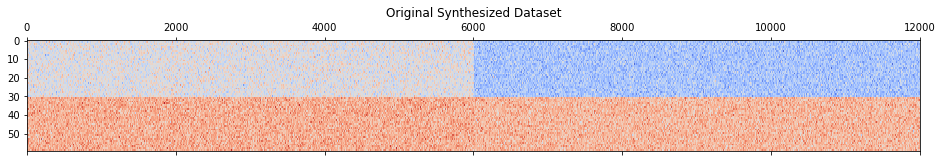

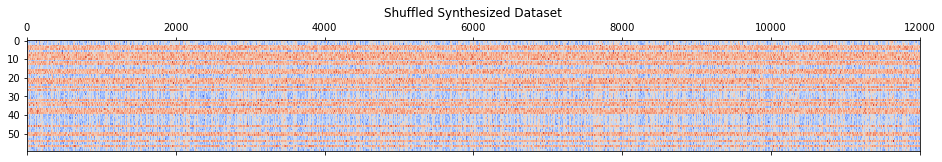

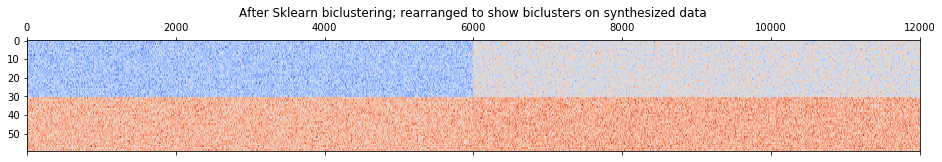

In [28]:
plt.matshow(data.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Original Synthesized Dataset", y=1.15)

datashuff, row_idx, col_idx = sg._shuffle(data, random_state=0)
plt.matshow(datashuff.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Shuffled Synthesized Dataset", y=1.15)

model = SpectralBiclustering(n_clusters=n_clusters, method='log',
                             random_state=0)
model.fit(datashuff)

fit_data = datashuff[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]

plt.matshow(fit_data.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("After Sklearn biclustering; rearranged to show biclusters on synthesized data", y=1.15)
plt.show()

In [30]:
#Implement our SSVD algorithm on synthesized data
[u1,v1,iters] = ssvd(data)
Xstar1 = np.outer(u1, v1.T)
X = data-Xstar1
xmax = np.max(np.abs(X))

In [31]:
v1sort = np.sort(v1)[::-1] #sort descending
u1sort = np.sort(u1)[::-1] #sort descending
x = np.outer(u1sort, v1sort.T)
xfake = x/xmax

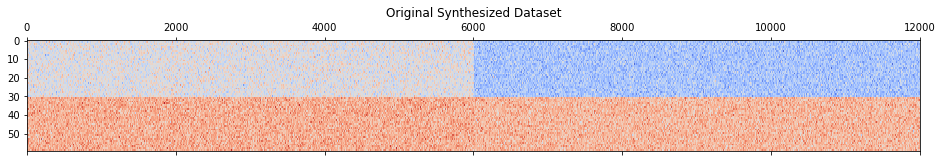

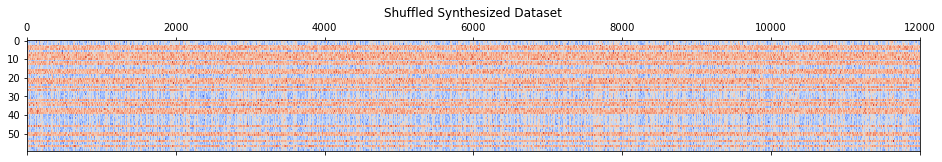

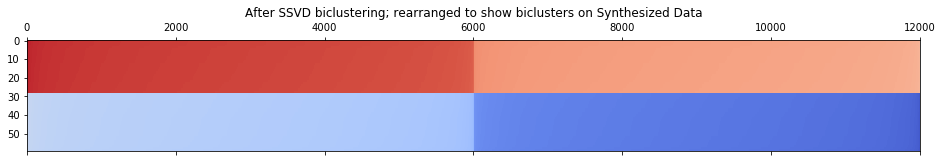

In [32]:
plt.matshow(data.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Original Synthesized Dataset", y=1.15)

datashuff, row_idx, col_idx = sg._shuffle(data, random_state=0)
plt.matshow(datashuff.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("Shuffled Synthesized Dataset", y=1.15)

plt.matshow(xfake.T, cmap=plt.cm.coolwarm_r, aspect='auto')
plt.title("After SSVD biclustering; rearranged to show biclusters on Synthesized Data", y=1.15)
plt.show()

#### Results show that the SSVD biclustering algorithm can recover the number of biclusters that were originally used to create the synthetic dataset. SSVD Biclustering is comparable to sklearn's Spectral Biclustering algorithm when the input matrix is non-sparse, but outperforms sklearn's algorithm when the input matrix is sparse.